# 计算机视觉课程作业
以下任务均在当前image-classifier.ipynb中执行，需要完整执行所有代码，并保存输出结果。完成任务后提交image-classifier.ipynb文件。
### 任务一：提升模型预测准确率
以下代码已经实现了基本的CIFAR-10图像分类。   
在不使用其他预训练模型下（即只能在CIFAR-10数据上从头训练模型），请通过数据增强、模型结构优化、更改优化策略（优化器，epoch，损失函数等）等方式提升模型预测准确率。   备注：数据增强，超参数（epoch，lr，momentum），损失函数criterion（默认交叉熵），优化器optimizer，模型net的结构调整
<font color=red>注意：成绩会通过“Step 5: Evaluate model accuracy”的输出结果Average Acc进行评分，请勿更改step 5的代码，且需要完整执行所有代码。</font>

### 任务二：T-SNE
使用pytorch中的hook提取测试集“testloader”在模型中间层的特征表示，并使用T-SNE方法进行可视化。   
<font color=red>注意：可视化结果应当作为"Step 6: T-SNE Visualization"的输出结果。</font>

## Step 1: Download a dataset and preview images

A model is only as good as its dataset.

Training tools need lots of high-quality data to build accurate models. We'll use the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) of 60,000 photos to build our image classifier. Get started by downloading the dataset with `torchvision` and previewing a handful of images from it.

Files already downloaded and verified
Files already downloaded and verified


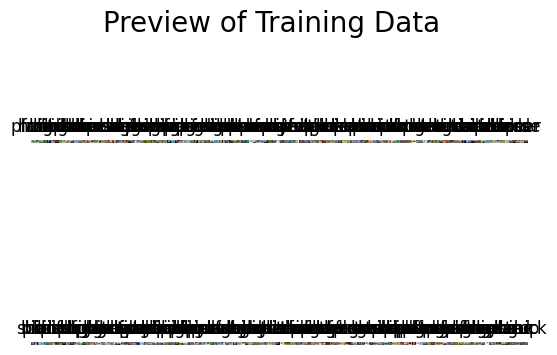

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Download the CIFAR-10 dataset to ./data
batch_size=256 # batch_size可调整
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
print("Downloading training data...")
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
print("Downloading testing data...")
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# Our model will recognize these kinds of objects
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Grab images from our training data
dataiter = iter(trainloader)
images, labels = dataiter.next()

for i in range(batch_size): # 根据batch size调整一下图的显示
    # Add new subplot
    plt.subplot(2, int(batch_size/2), i + 1)
    # Plot the image
    img = images[i]
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    # Add the image's label
    plt.title(classes[labels[i]])

plt.suptitle('Preview of Training Data', size=20)
plt.show()

# Step 2: Configure the neural network

Now that we have our dataset, we need to set up a neural network for PyTorch. Our neural network will transform an image into a description.

In [8]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Define a convolutional neural network
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
net = Net()

# Define a loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001,
                      momentum=0.9, weight_decay=5e-4) # 学习率和其他参数可以调整，优化器可以改变


print("Your network is ready for training!")

Your network is ready for training!


In [2]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class AlexNet(nn.Module):
    def __init__(self, width_mult=1):
        super(AlexNet, self).__init__()
        # 定义每一个就卷积层
        self.layer1 = nn.Sequential(
            # 卷积层  #输入图像为1*28*28
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            # 池化层
            nn.MaxPool2d(kernel_size=2, stride=2),  # 池化层特征图通道数不改变，每个特征图的分辨率变小
            # 激活函数Relu
            nn.ReLU(inplace=True),
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.ReLU(inplace=True),
        )

        # 定义全连接层
        self.fc1 = nn.Linear(256 * 3 * 3, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)
        # 对应十个类别的输出

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        # print(x.shape)
        x = x.view(-1, 256 * 3 * 3)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)

        return x    
net = AlexNet()

# Define a loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9) # 学习率和其他参数可以调整，优化器可以改变


print("Your network is ready for training!")

Your network is ready for training!


In [21]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


# cfg = {
#    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
#    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
#    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
#    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
# }

cfg = {'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']}

class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, 10)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)

net = VGG()

# Define a loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4) # 学习率和其他参数可以调整，优化器可以改变


print("Your network is ready for training!")


Your network is ready for training!


# Step 3: Train the network and save model

PyTorch trains our network by adjusting its parameters and evaluating its performance against our labelled dataset.

In [3]:
from tqdm import tqdm

EPOCHS = 50 # epoch可调整
print("Training...")

# 进入训练模式
net.train()
for epoch in range(EPOCHS):
    running_loss = 0.0
    for i, data in enumerate(tqdm(trainloader, desc=f"Epoch {epoch + 1} of {EPOCHS}", leave=True, ncols=80)):
        inputs, labels = data

        optimizer.zero_grad()# 梯度清零
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()# 反向传播计算梯度
        optimizer.step()# 更新参数

# Save our trained model
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

Training...


Epoch 11 of 50:   1%|▏                          | 1/196 [00:01<03:38,  1.12s/it]

# Step 4: Test the trained model

Let's test our model!

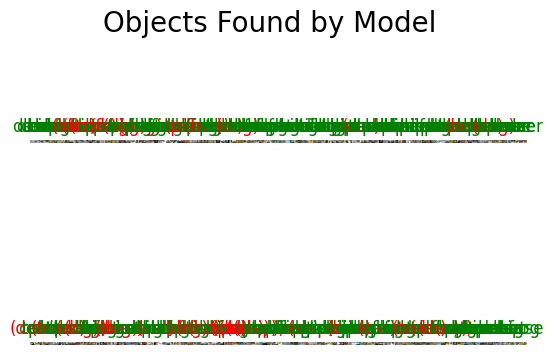

In [17]:
# Pick random photos from training set
if dataiter == None:
    dataiter = iter(testloader)
images, labels = dataiter.next()

# Load our model
net = Net()
net.load_state_dict(torch.load(PATH))

# Analyze images
outputs = net(images)
_, predicted = torch.max(outputs, 1)

# Show results
for i in range(batch_size):
    # Add new subplot
    plt.subplot(2, int(batch_size/2), i + 1)
    # Plot the image
    img = images[i]
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    # Add the image's label
    color = "green"
    label = classes[predicted[i]]
    if classes[labels[i]] != classes[predicted[i]]:
        color = "red"
        label = "(" + label + ")"
    plt.title(label, color=color)

plt.suptitle('Objects Found by Model', size=20)
plt.show()

# Step 5: Evaluate model accuracy

Let's conclude by evaluating our model's overall performance.

In [18]:
# Measure accuracy for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# Print accuracy statistics
average_accuray = []
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    average_accuray.append(accuracy)
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')
print ('Average Acc:', np.mean(average_accuray))

Accuracy for class: plane is 69.9 %
Accuracy for class: car   is 75.1 %
Accuracy for class: bird  is 44.6 %
Accuracy for class: cat   is 37.4 %
Accuracy for class: deer  is 53.9 %
Accuracy for class: dog   is 53.7 %
Accuracy for class: frog  is 64.6 %
Accuracy for class: horse is 71.1 %
Accuracy for class: ship  is 74.0 %
Accuracy for class: truck is 69.0 %
Average Acc: 61.33


# 任务二：T-SNE

# Step 6: T-SNE Visualization

Visualize high-dimensional data in a low-dimensional space using T-SNE.

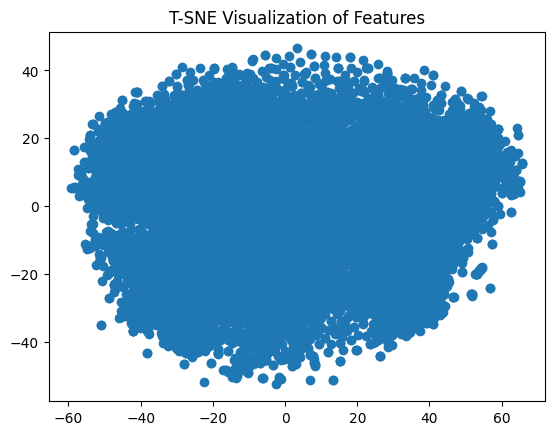

In [19]:
from sklearn.manifold import TSNE
# 定义一个hook函数，用于捕获中间层的特征
features = []

def hook_fn(module, input, output):
    features.append(output)

# 注册hook到模型的某一层，例如第一个全连接层
net.fc1.register_forward_hook(hook_fn)

# 运行模型，提取特征
net.eval()
with torch.no_grad():
    for inputs, labels in testloader:
        outputs = net(inputs)

# 提取特征并转换为NumPy数组
features = torch.cat(features, dim=0).numpy()

# 使用T-SNE进行降维
tsne = TSNE(n_components=2, random_state=0)
features_tsne = tsne.fit_transform(features)

# 可视化T-SNE降维后的特征
plt.scatter(features_tsne[:, 0], features_tsne[:, 1])
plt.title('T-SNE Visualization of Features')
plt.show()